# **Connceting to Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops


## **Initialising the base paths**

In [3]:
import os

base_path = '/content/drive/MyDrive/PlantDataSet'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')
val_dir = os.path.join(base_path, 'validation')


In [4]:
import tensorflow as tf

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(150, 150), batch_size=32)
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=(150, 150), batch_size=32)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(150, 150), batch_size=32)


Found 38104 files belonging to 13 classes.
Found 9458 files belonging to 13 classes.
Found 5741 files belonging to 13 classes.


# **Image Preprocessing**

In [ ]:
import tensorflow as tf

def preprocess_image(image):
    # Resize image
    image = tf.image.resize(image, [150, 150])

    # Normalize image (scale pixel values to [0, 1])
    image = image / 255.0

    # Apply basic image processing techniques
    flipped = tf.image.flip_left_right(image)                      # Flip horizontally
    bright = tf.image.adjust_brightness(image, 0.3)               # Brightness adjustment
    contrast = tf.image.adjust_contrast(image, 2)                 # Contrast adjustment
    rotated = tf.image.rot90(image)                               # Rotate 90 degrees
    cropped = tf.image.central_crop(image, central_fraction=0.8)  # Central crop

    # Advanced image processing using TensorFlow
    def add_random_noise(image):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
        return tf.clip_by_value(image + noise, 0.0, 1.0)

    # Applying advanced techniques
    noisy = add_random_noise(image)  # Add random noise

    # Return all processed versions in a dictionary
    return {
        "original": image,
        "flipped": flipped,
        "bright": bright,
        "contrast": contrast,
        "rotated": rotated,
        "cropped": cropped,
        "noisy": noisy
    }


# **Visualizing the Preprocessed Image :**

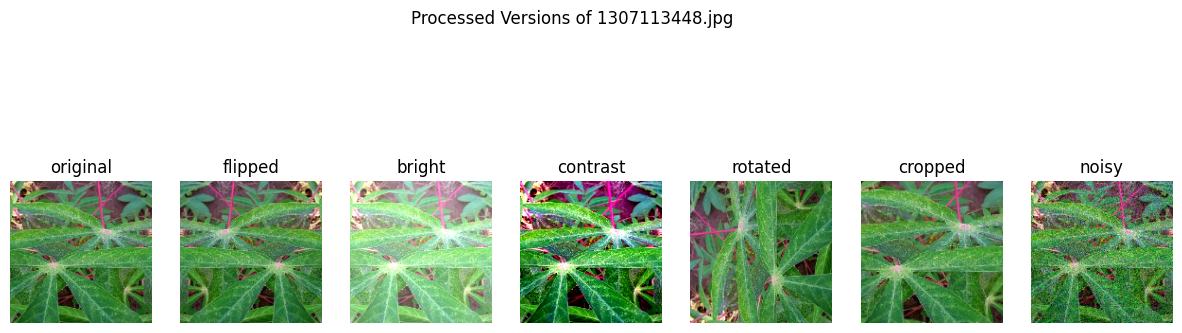

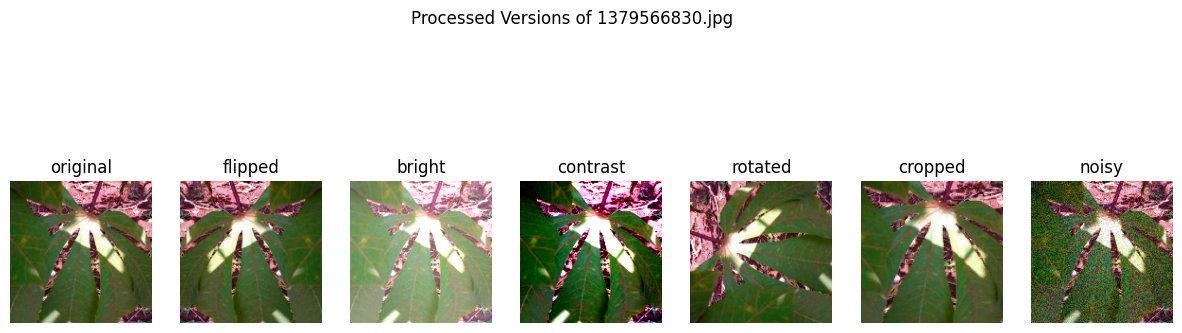

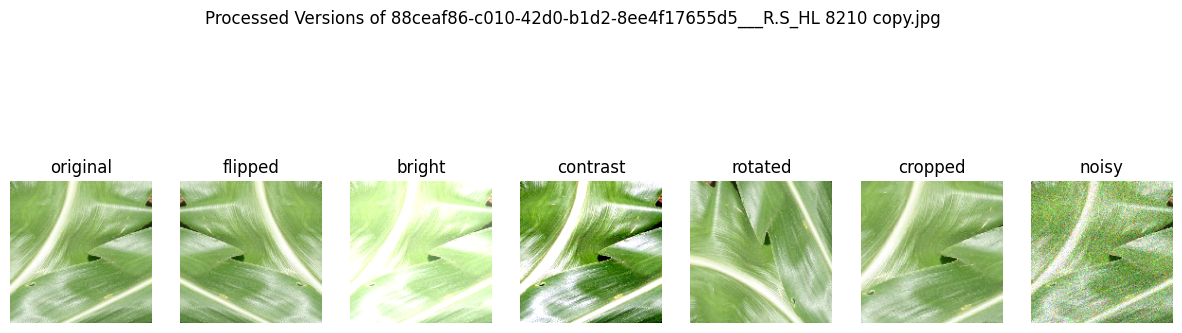

In [ ]:
#########################################################################################################################################################
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf

def load_image(image_path):
    """Load an image from a file path."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def visualize_processed_images(processed_images, title):
    """Visualize processed images from a dictionary."""
    fig, axes = plt.subplots(1, len(processed_images), figsize=(15, 5))
    for ax, (key, img) in zip(axes, processed_images.items()):
        ax.imshow(img)
        ax.set_title(key)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

def process_and_visualize_random_images(image_dir, num_images=3):
    """
    Selects random images from the dataset, applies preprocessing,
    and visualizes the processed versions.
    """
    # List all image file paths in the directory
    all_image_paths = [os.path.join(root, file)
                       for root, _, files in os.walk(image_dir)
                       for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Select random images
    selected_image_paths = random.sample(all_image_paths, num_images)

    for image_path in selected_image_paths:
        # Load and preprocess the image
        image = load_image(image_path)
        processed_images = preprocess_image(image)

        # Convert TensorFlow tensors to NumPy arrays for visualization
        processed_images_np = {key: img.numpy() for key, img in processed_images.items()}

        # Visualize the processed images
        visualize_processed_images(processed_images_np, title=f"Processed Versions of {os.path.basename(image_path)}")

# Example usage
process_and_visualize_random_images(train_dir, num_images=3)


In [ ]:
# Apply preprocessing only once
def map_preprocessing_function(image, label):
    processed_versions = preprocess_image(image)  # Process image tensor
    return processed_versions['original'], label  # Return original version

# Load dataset with caching and prefetching
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, labels='inferred', batch_size=32, image_size=(150, 150)
).map(map_preprocessing_function).cache().prefetch(tf.data.AUTOTUNE)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir, labels='inferred', batch_size=32, image_size=(150, 150)
).map(map_preprocessing_function).cache().prefetch(tf.data.AUTOTUNE)


Found 38104 files belonging to 13 classes.
Found 9458 files belonging to 13 classes.


# **Segementation**

# **Visualizing the Segmented Image :**

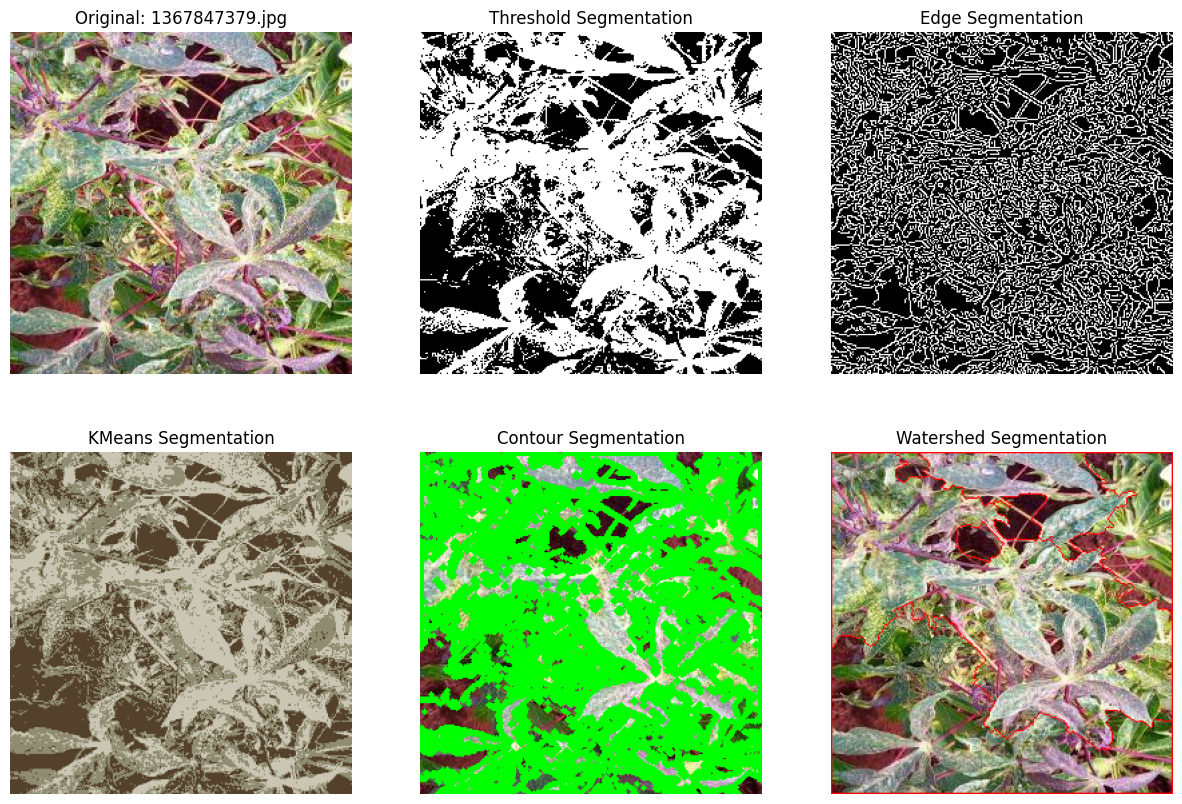

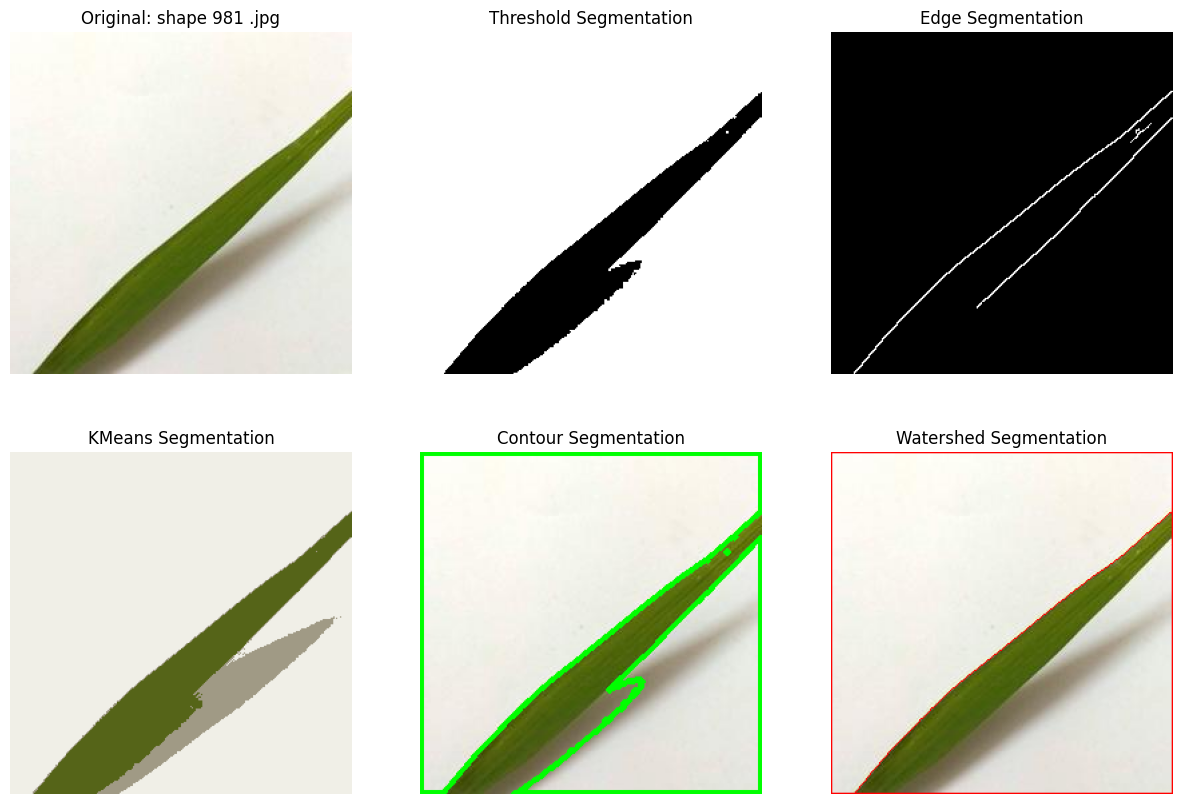

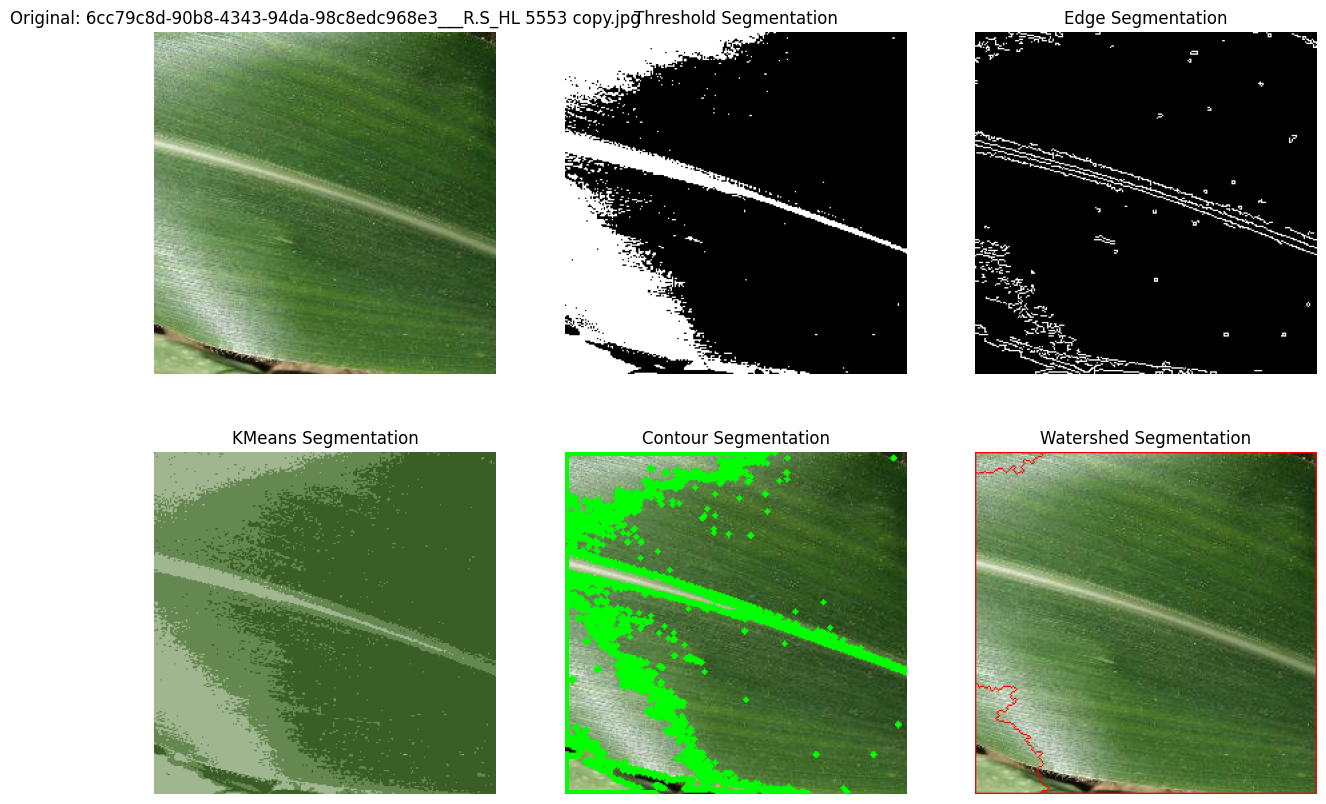

In [5]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def load_image_cv2(image_path):
    """Load an image from a file path using OpenCV in RGB format."""
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 1. Threshold Segmentation
def threshold_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    segmented = cv2.bitwise_and(image, image, mask=threshold)
    return threshold, segmented

# 2. Edge Segmentation
def edge_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    segmented = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return edges, segmented

# 3. KMeans Segmentation (Region-Based)
def kmeans_segmentation(image, n_clusters=3):
    img_data = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(img_data)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_].reshape(image.shape).astype(np.uint8)
    return segmented_img

# 4. Contour Segmentation
def contour_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmented = image.copy()
    cv2.drawContours(segmented, contours, -1, (0, 255, 0), 3)
    return contours, segmented

# 5. Watershed Segmentation
def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv2.dilate(thresh, kernel, iterations=1)
    distance_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(distance_transform, 0.7 * distance_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = cv2.dilate(dilation, kernel, iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)
    markers = cv2.connectedComponents(sure_fg)[1] + 1
    markers[unknown == 255] = 0
    segmented = image.copy()
    cv2.watershed(segmented, markers)
    segmented[markers == -1] = [255, 0, 0]  # Mark boundaries in red
    return segmented

# Visualization Function
def visualize_segmentation_results(original, threshold, edge, kmeans, contour, watershed, title):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title(f"Original: {title}")
    plt.axis("off")
    plt.subplot(2, 3, 2)
    plt.imshow(threshold, cmap='gray')
    plt.title("Threshold Segmentation")
    plt.axis("off")
    plt.subplot(2, 3, 3)
    plt.imshow(edge, cmap='gray')
    plt.title("Edge Segmentation")
    plt.axis("off")
    plt.subplot(2, 3, 4)
    plt.imshow(kmeans)
    plt.title("KMeans Segmentation")
    plt.axis("off")
    plt.subplot(2, 3, 5)
    plt.imshow(contour)
    plt.title("Contour Segmentation")
    plt.axis("off")
    plt.subplot(2, 3, 6)
    plt.imshow(watershed)
    plt.title("Watershed Segmentation")
    plt.axis("off")
    plt.show()

# Processing Function
def process_and_visualize_random_leaf_images(image_dir, num_images=3):
    all_image_paths = [os.path.join(root, file)
                       for root, _, files in os.walk(image_dir)
                       for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
    selected_image_paths = random.sample(all_image_paths, num_images)
    for image_path in selected_image_paths:
        image = load_image_cv2(image_path)
        threshold, _ = threshold_segmentation(image)
        edge, _ = edge_segmentation(image)
        kmeans = kmeans_segmentation(image)
        contours, contour_image = contour_segmentation(image)
        watershed = watershed_segmentation(image)
        visualize_segmentation_results(image, threshold, edge, kmeans, contour_image, watershed, os.path.basename(image_path))

# Example usage
process_and_visualize_random_leaf_images(train_dir, num_images=3)


# **Feature Extraction Functions :**

In [ ]:
!pip uninstall -y scikit-image
!pip install scikit-image==0.19.3


Found existing installation: scikit-image 0.25.0
Uninstalling scikit-image-0.25.0:
  Successfully uninstalled scikit-image-0.25.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.7 MB/s eta 0:00:00


# **Visualizing the Extracted Features :**

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

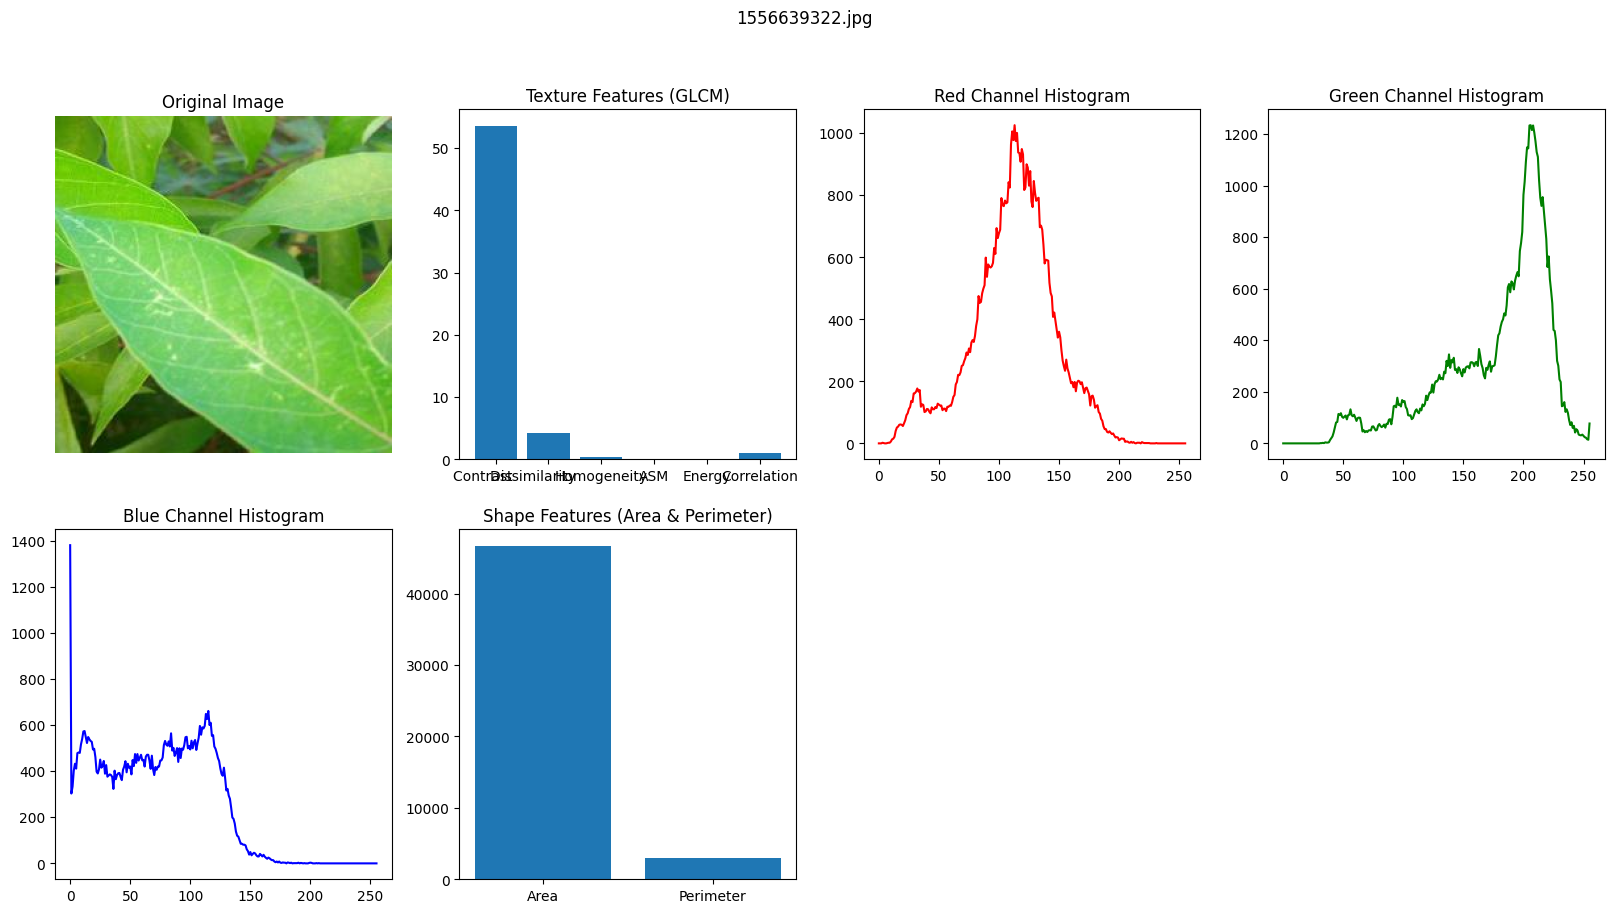

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

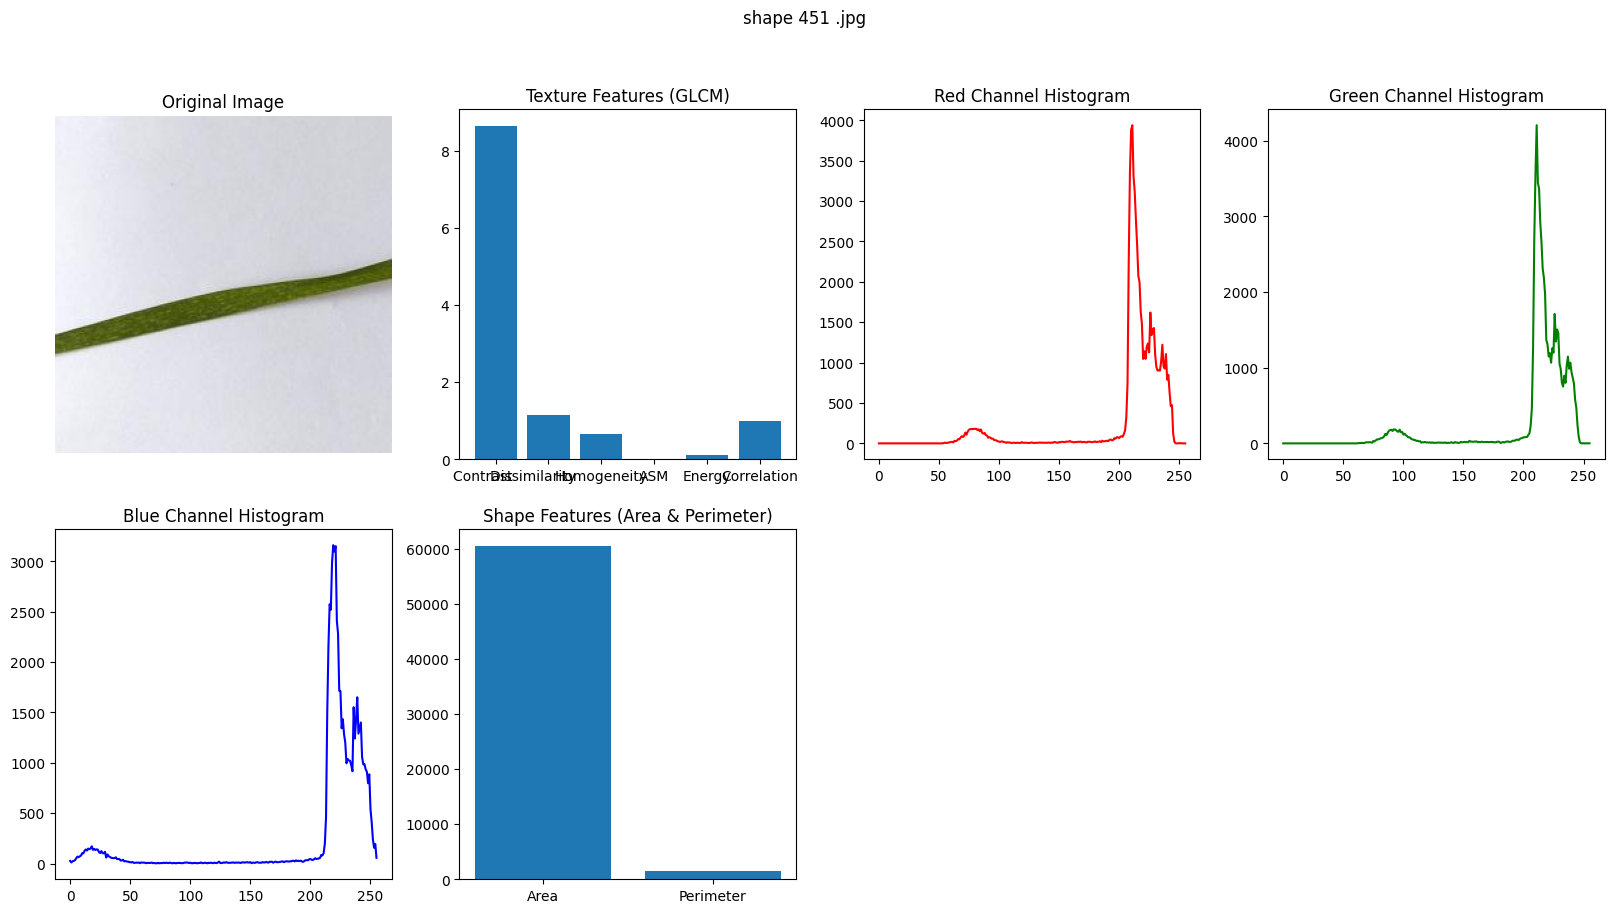

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

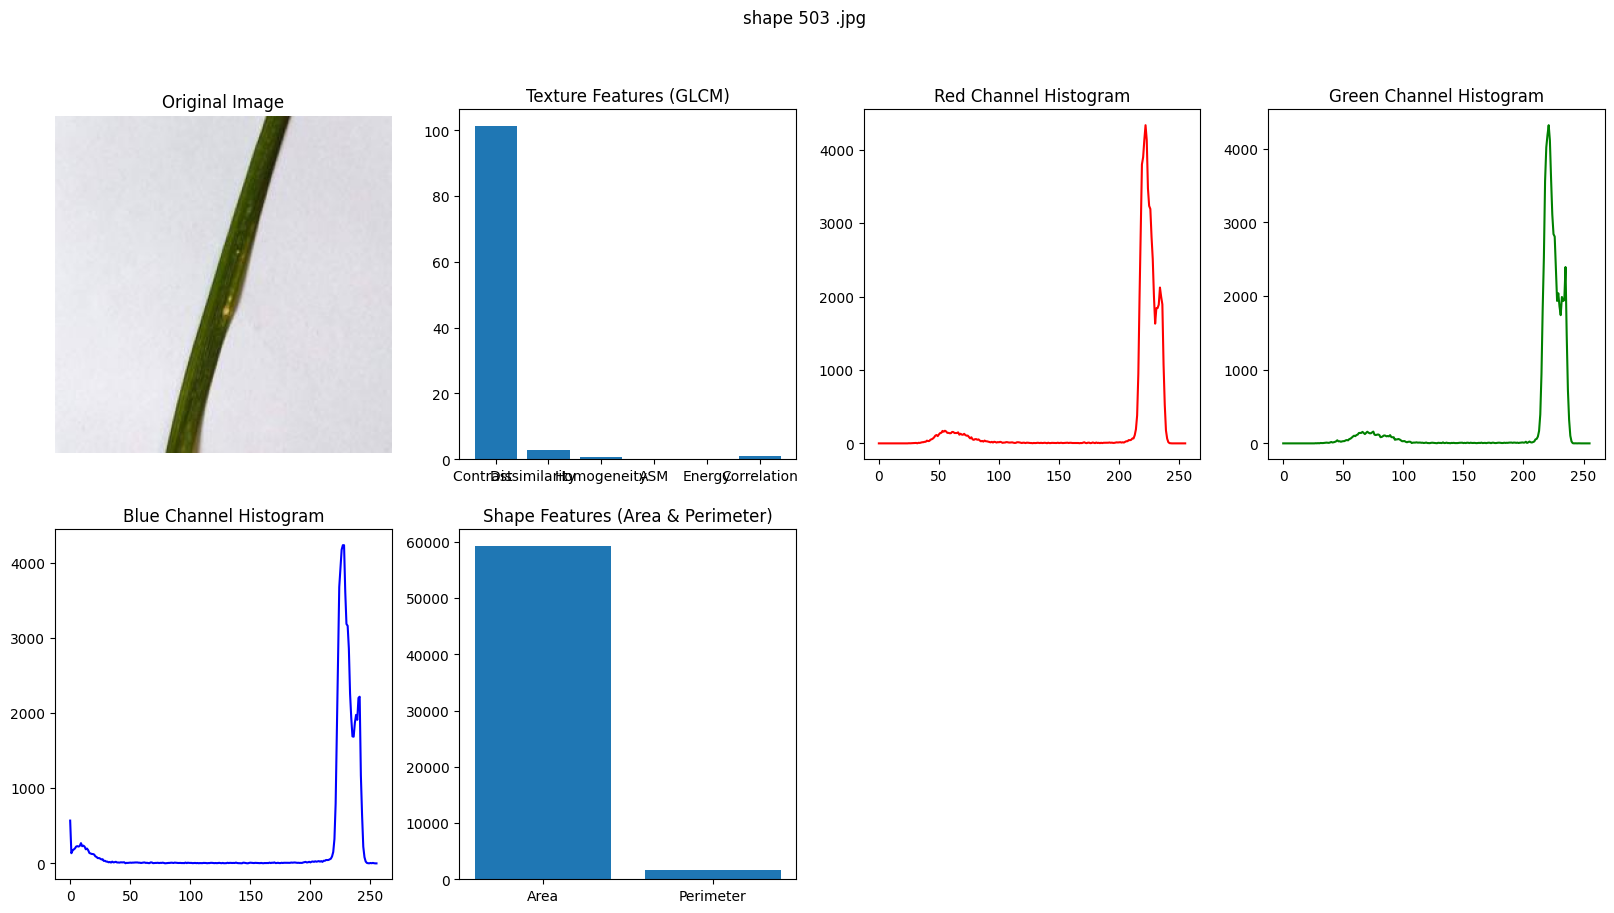

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops
from skimage.color import rgb2gray

# Helper function to load an image using OpenCV
def load_image_cv2(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return image

# Function to extract texture features using GLCM
def extract_texture_features_glcm(image):
    gray = rgb2gray(image)  # Convert to grayscale
    glcm = greycomatrix((gray * 255).astype(np.uint8), [1], [0], symmetric=True, normed=True)

    # Extract GLCM features: contrast, dissimilarity, homogeneity, ASM, energy, correlation
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    asm = greycoprops(glcm, 'ASM')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]

    return np.array([contrast, dissimilarity, homogeneity, asm, energy, correlation])

# Function to extract color histogram features (RGB)
def extract_color_histogram_features(image):
    # Calculate color histograms for each channel (Red, Green, Blue)
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])

    return hist_r.flatten(), hist_g.flatten(), hist_b.flatten()

# Function to extract shape features (area and perimeter) using contours
def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    perimeters = [cv2.arcLength(c, True) for c in contours]
    return np.array([np.sum(areas), np.sum(perimeters)])

# Full feature extraction function for segmented images
def extract_features_from_segmented_image(image):
    texture = extract_texture_features_glcm(image)
    color_hist_r, color_hist_g, color_hist_b = extract_color_histogram_features(image)
    shape = extract_shape_features(image)

    # Combine all features into a single vector
    features = np.concatenate([texture, color_hist_r, color_hist_g, color_hist_b, shape])
    return features

# Function to visualize the features and histograms
def visualize_segmented_image_features(image, features, title):
    """
    Visualizes extracted features (texture, color histogram, and shape) in an image-like format.
    """
    texture_features = features[:6]  # GLCM features (contrast, dissimilarity, etc.)
    color_hist_r = features[6:262]
    color_hist_g = features[262:518]
    color_hist_b = features[518:774]
    shape_features = features[774:]

    # Create feature "images"
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Display original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")

    # Display GLCM features as a bar plot
    axes[0, 1].bar(['Contrast      ', 'Dissimilarity       ', 'Homogeneity', 'ASM', 'Energy', 'Correlation'],
                   texture_features)
    axes[0, 1].set_title("Texture Features (GLCM)")

    # Display color histograms for each channel
    axes[0, 2].plot(color_hist_r, color='r')
    axes[0, 2].set_title("Red Channel Histogram")
    axes[0, 3].plot(color_hist_g, color='g')
    axes[0, 3].set_title("Green Channel Histogram")

    axes[1, 0].plot(color_hist_b, color='b')
    axes[1, 0].set_title("Blue Channel Histogram")

    # Display shape features (area and perimeter)
    axes[1, 1].bar(['Area', 'Perimeter'], shape_features)
    axes[1, 1].set_title("Shape Features (Area & Perimeter)")

    axes[1, 2].axis("off")
    axes[1, 3].axis("off")

    plt.suptitle(title)
    plt.show()

# Function to process and visualize random segmented images from a dataset
def process_and_visualize_segmented_images(image_dir, num_images=3):
    """
    Selects random images from the dataset, extracts features,
    and visualizes the original image and extracted features in image format.
    """
    # List all image file paths in the directory
    all_image_paths = [os.path.join(root, file)
                       for root, _, files in os.walk(image_dir)
                       for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Select random images
    selected_image_paths = random.sample(all_image_paths, num_images)

    for image_path in selected_image_paths:
        # Load the image
        image = load_image_cv2(image_path)

        # Extract features from the segmented image
        features = extract_features_from_segmented_image(image)

        # Visualize the extracted features
        visualize_segmented_image_features(image, features, title=os.path.basename(image_path))

# Example usage
train_dir = '/content/drive/MyDrive/PlantDataSet/train'
process_and_visualize_segmented_images(train_dir, num_images=3)
